## MODELOS DE LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR PETROLERO EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos la data de Demanda de gas en sector petrolero como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Se lee la data "original" de Demanda en sector eléctrico

In [2]:
csv_demanda_petrolero_original = pd.read_csv('Demanda_petrolero_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_petrolero_original

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2022-05-01,1919.43
2022-06-01,1876.88
2022-07-01,1979.70


Se grafica la data "original" de Demanda en sector petrolero

Text(0, 0.5, 'Demanda [MMpcd]')

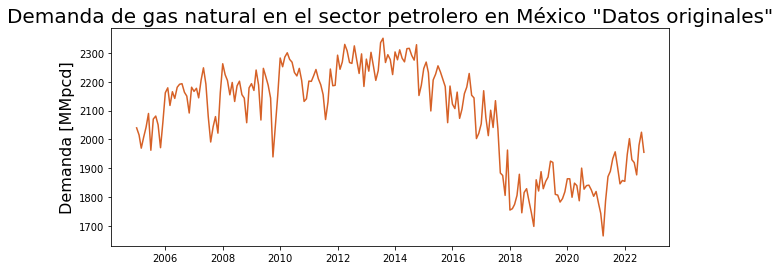

In [4]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_petrolero_original, color='#D66127')
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector petrolero en sus compoentes de Tendencia, Estacionalidad y Residual

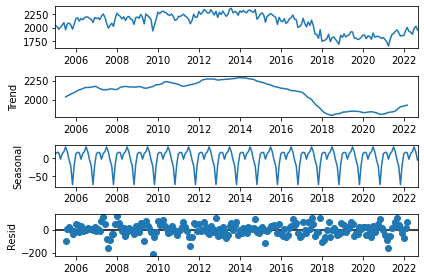

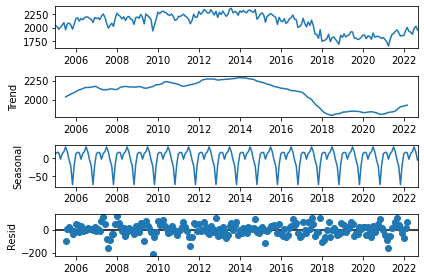

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_petrolero_original_seasonal_decomposition = seasonal_decompose(csv_demanda_petrolero_original)
csv_demanda_petrolero_original_seasonal_decomposition.plot()

Separamos la data original de Demanda de gas natural en el sector petrolero en data de train y test

In [6]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_petrolero_original_train_data = csv_demanda_petrolero_original[:-num_test_points]
demanda_petrolero_original_test_data = csv_demanda_petrolero_original[-num_test_points:]

demanda_petrolero_original_train_data

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


Se grafica la distribución de la data "original" de TRAIN de Demanda en sector petrolero

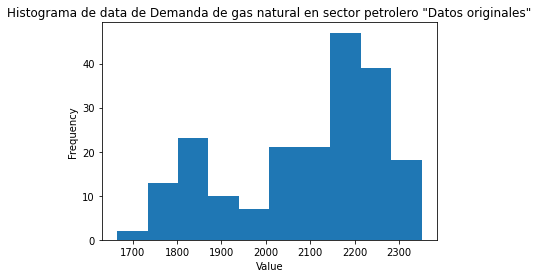

In [7]:
# Generate the histogram
plt.hist(demanda_petrolero_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos originales"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos originales de TRAIN de Demanda en sector petrolero

In [8]:
import scipy.stats as stats

# Assuming demanda_petrolero_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_original_train_data.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.202047251153015
p-value: 4.1037526656295675e-05


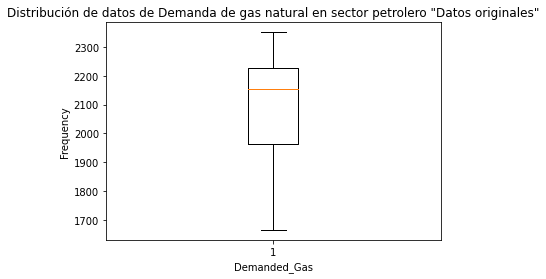

In [9]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector petrolero "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
n_input = 24

data = demanda_petrolero_original_train_data['Demanded_Gas'].values
targets = data 

demanda_petrolero_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [12]:
demanda_petrolero_original_train_generator[0]

(array([[2039.88, 2015.25, 1969.51, 2008.19, 2041.86, 2089.82, 1962.26,
         2070.46, 2080.82, 2050.56, 1971.14, 2059.68, 2161.66, 2178.75,
         2117.61, 2165.25, 2142.03, 2180.68, 2191.06, 2193.12, 2163.43,
         2150.04, 2091.42, 2180.87]]),
 array([2166.37]))

In [13]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_original_train_data)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_original_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector petrolero

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [14]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [16]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_sin_tratamiento = Sequential()
model_LSTM_petrolero_sin_tratamiento.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_sin_tratamiento.add(Dense(1))
model_LSTM_petrolero_sin_tratamiento.compile(optimizer='adam', loss='mse')

In [17]:
model_LSTM_petrolero_sin_tratamiento.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo LSTM

In [18]:
model_LSTM_petrolero_sin_tratamiento.fit(demanda_petrolero_original_train_generator, epochs=15)


Epoch 1/15


177/177 [==============================] - 4s 10ms/step - loss: 1358066.5000
Epoch 2/15
177/177 [==============================] - 2s 9ms/step - loss: 512637.8750
Epoch 3/15
177/177 [==============================] - 1s 8ms/step - loss: 11726.4795
Epoch 4/15
177/177 [==============================] - 2s 9ms/step - loss: 12251.7256
Epoch 5/15
177/177 [==============================] - 1s 8ms/step - loss: 12147.3633
Epoch 6/15
177/177 [==============================] - 1s 8ms/step - loss: 12039.7920
Epoch 7/15
177/177 [==============================] - 2s 9ms/step - loss: 12017.7588
Epoch 8/15
177/177 [==============================] - 2s 9ms/step - loss: 11797.0322
Epoch 9/15
177/177 [==============================] - 2s 9ms/step - loss: 11408.0889
Epoch 10/15
177/177 [==============================] - 1s 8ms/step - loss: 11286.4678
Epoch 11/15
177/177 [==============================] - 2s 9ms/step - loss: 11688.1641
Epoch 12/15
177/177 [==============================] - 2s 8ms/step - l

Se grafica la perdida por epoch

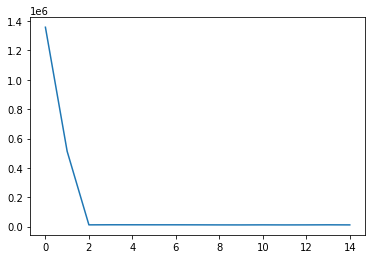

In [19]:
loss_per_epoch_model_FF = model_LSTM_petrolero_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_electrico_sin_tratamiento previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [21]:
data = demanda_petrolero_original_train_data['Demanded_Gas'].values

demanda_petrolero_train_batch_sin_tratamiento = data[-n_input:]

demanda_petrolero_train_batch_sin_tratamiento

array([1782.6 , 1794.63, 1818.35, 1863.28, 1863.28, 1799.17, 1848.19,
       1839.68, 1786.97, 1900.31, 1827.31, 1839.67, 1841.23, 1824.71,
       1802.58, 1819.26, 1778.16, 1743.17, 1665.17, 1785.32, 1870.67,
       1889.2 , 1933.02, 1956.84])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [22]:
demanda_petrolero_train_batch_sin_tratamiento_reshaped = demanda_petrolero_train_batch_sin_tratamiento.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_sin_tratamiento_reshaped

array([[[1782.6 ],
        [1794.63],
        [1818.35],
        [1863.28],
        [1863.28],
        [1799.17],
        [1848.19],
        [1839.68],
        [1786.97],
        [1900.31],
        [1827.31],
        [1839.67],
        [1841.23],
        [1824.71],
        [1802.58],
        [1819.26],
        [1778.16],
        [1743.17],
        [1665.17],
        [1785.32],
        [1870.67],
        [1889.2 ],
        [1933.02],
        [1956.84]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [23]:
model_LSTM_petrolero_sin_tratamiento.predict(demanda_petrolero_train_batch_sin_tratamiento_reshaped)

1/1 [==============================] - 1s 1s/step


array([[1858.5691]], dtype=float32)

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos de test de la demanda de gasd natural en sector eléctrico

In [24]:
demanda_petrolero_original_test_data['Demanded_Gas'].values[0]

1904.21

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [25]:
n_input = 24
n_features = 1

In [26]:
test_predictions_model_LSTM_petrolero_sin_pretratamiento = []

first_eval_batch = demanda_petrolero_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_sin_tratamiento.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


In [27]:
test_predictions_model_LSTM_petrolero_sin_pretratamiento

[array([1858.5691], dtype=float32),
 array([1865.1176], dtype=float32),
 array([1868.8248], dtype=float32),
 array([1869.6251], dtype=float32),
 array([1869.2668], dtype=float32),
 array([1863.8859], dtype=float32),
 array([1865.338], dtype=float32),
 array([1867.7688], dtype=float32),
 array([1866.4813], dtype=float32),
 array([1870.2479], dtype=float32),
 array([1868.833], dtype=float32),
 array([1865.6428], dtype=float32)]

Se grafican los 12 meses de test vs el forecast del modelo LSTM sin la data pretratada

Text(0, 0.5, 'Demanda [MMpcd]')

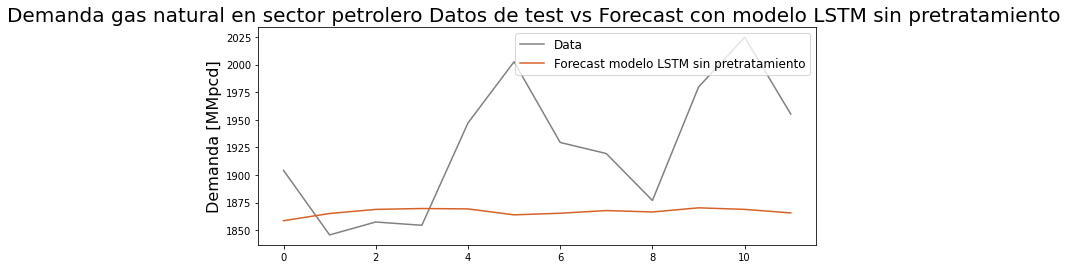

In [29]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_sin_pretratamiento, color='#D66127')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector petrolero Datos de test vs Forecast con modelo LSTM sin pretratamiento ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo LSTM sin la data pretratada

In [30]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_petrolero_sin_pretratamiento = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_sin_pretratamiento)
RMSE_predictions_model_LSTM_petrolero_sin_pretratamiento= np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_sin_pretratamiento))

print('MAPE:', MAPE_predictions_model_LSTM_petrolero_sin_pretratamiento)
print('RMSE:', RMSE_predictions_model_LSTM_petrolero_sin_pretratamiento)

MAPE: 0.033493478229593775
RMSE: 81.31893214613582


## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [31]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [32]:
outlier_threshold = 1.1

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [33]:
demanda_petrolero_original_train_para_tratamiento =demanda_petrolero_original_train_data.copy()
demanda_petrolero_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


In [35]:
demanda_petrolero_train_pretratamiento_media = remove_replace_outliers_media(demanda_petrolero_original_train_para_tratamiento['Demanded_Gas'])
demanda_petrolero_train_pretratamiento_media.tail(10)

Date
2020-12-01    1802.5800
2021-01-01    1819.2600
2021-02-01    1778.1600
2021-03-01    1743.1700
2021-04-01    2094.9368
2021-05-01    1785.3200
2021-06-01    1870.6700
2021-07-01    1889.2000
2021-08-01    1933.0200
2021-09-01    1956.8400
Name: Demanded_Gas, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

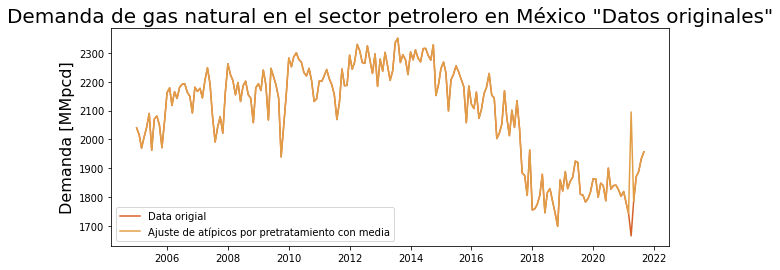

In [36]:
plt.figure(figsize=(10,4))
plt.plot(demanda_petrolero_original_train_data, color='#D66127')
plt.plot(demanda_petrolero_train_pretratamiento_media,color='#E29E46')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de media artimetica de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

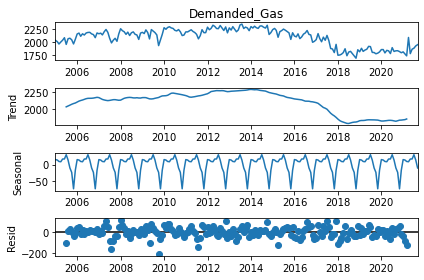

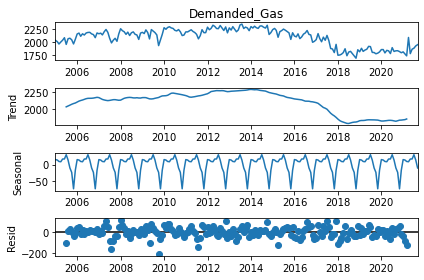

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_petrolero_train_pretratamiento_media_seasonal_decomposition = seasonal_decompose(demanda_petrolero_train_pretratamiento_media)
demanda_petrolero_train_pretratamiento_media_seasonal_decomposition.plot()

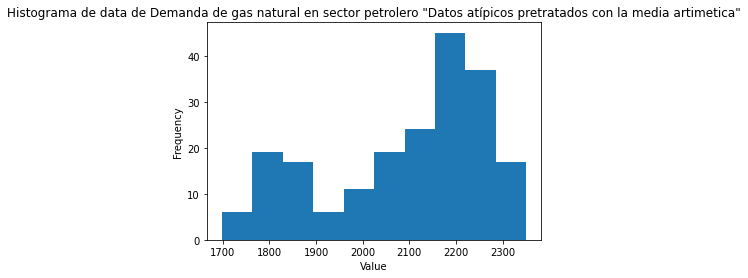

In [38]:
# Generate the histogram
plt.hist(demanda_petrolero_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector petrolero para el caso de pretratamiento con la media artimetica

In [39]:
import scipy.stats as stats

# Assuming demanda_petrolero_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.123739937957446
p-value: 4.2676165909916186e-05


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

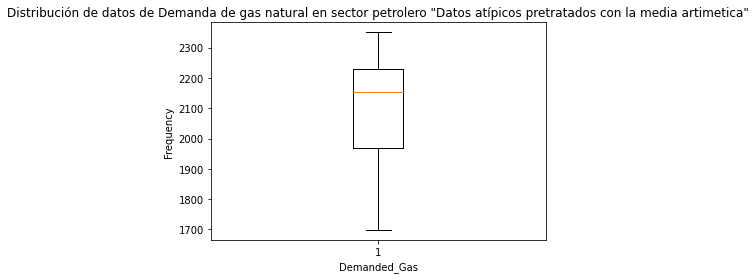

In [40]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [41]:
n_input = 24

data = demanda_petrolero_train_pretratamiento_media
targets = data 

demanda_petrolero_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [42]:
demanda_petrolero_train_generator_pretratamiento_media[0]

(array([[2039.88, 2015.25, 1969.51, 2008.19, 2041.86, 2089.82, 1962.26,
         2070.46, 2080.82, 2050.56, 1971.14, 2059.68, 2161.66, 2178.75,
         2117.61, 2165.25, 2142.03, 2180.68, 2191.06, 2193.12, 2163.43,
         2150.04, 2091.42, 2180.87]]),
 array([2166.37]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [43]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_train_pretratamiento_media)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_train_generator_pretratamiento_media))

Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [44]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [45]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_pretratamiento_media = Sequential()
model_LSTM_petrolero_pretratamiento_media.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_pretratamiento_media.add(Dense(1))
model_LSTM_petrolero_pretratamiento_media.compile(optimizer='adam', loss='mse')

In [46]:
model_LSTM_petrolero_pretratamiento_media.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [47]:
model_LSTM_petrolero_pretratamiento_media.fit(demanda_petrolero_train_generator_pretratamiento_media, epochs=15)

Epoch 1/25


177/177 [==============================] - 4s 10ms/step - loss: 1715050.1250
Epoch 2/25
177/177 [==============================] - 1s 8ms/step - loss: 219889.8125
Epoch 3/25
177/177 [==============================] - 1s 8ms/step - loss: 27479.7988
Epoch 4/25
177/177 [==============================] - 1s 8ms/step - loss: 294667.6250
Epoch 5/25
177/177 [==============================] - 2s 9ms/step - loss: 80135.2734
Epoch 6/25
177/177 [==============================] - 2s 9ms/step - loss: 103475.5000
Epoch 7/25
177/177 [==============================] - 1s 8ms/step - loss: 16886.6777
Epoch 8/25
177/177 [==============================] - 2s 8ms/step - loss: 14144.4746
Epoch 9/25
177/177 [==============================] - 1s 8ms/step - loss: 13017.9043
Epoch 10/25
177/177 [==============================] - 1s 8ms/step - loss: 15096.5186
Epoch 11/25
177/177 [==============================] - 2s 9ms/step - loss: 16771.6094
Epoch 12/25
177/177 [==============================] - 1s 8ms/step -

Se grafica la perdida por epoch 

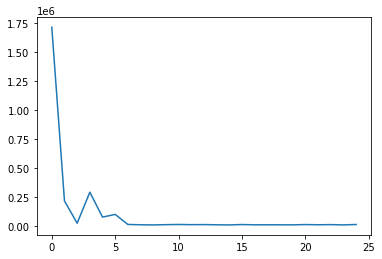

In [48]:
loss_per_epoch = model_LSTM_petrolero_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [49]:
demanda_petrolero_train_batch_pretratamiento_media = demanda_petrolero_train_pretratamiento_media.values[-n_input:]


demanda_petrolero_train_batch_pretratamiento_media

array([1782.6   , 1794.63  , 1818.35  , 1863.28  , 1863.28  , 1799.17  ,
       1848.19  , 1839.68  , 1786.97  , 1900.31  , 1827.31  , 1839.67  ,
       1841.23  , 1824.71  , 1802.58  , 1819.26  , 1778.16  , 1743.17  ,
       2094.9368, 1785.32  , 1870.67  , 1889.2   , 1933.02  , 1956.84  ])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [50]:
demanda_petrolero_train_batch_pretratamiento_media_reshaped = demanda_petrolero_train_batch_pretratamiento_media.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_pretratamiento_media_reshaped

array([[[1782.6   ],
        [1794.63  ],
        [1818.35  ],
        [1863.28  ],
        [1863.28  ],
        [1799.17  ],
        [1848.19  ],
        [1839.68  ],
        [1786.97  ],
        [1900.31  ],
        [1827.31  ],
        [1839.67  ],
        [1841.23  ],
        [1824.71  ],
        [1802.58  ],
        [1819.26  ],
        [1778.16  ],
        [1743.17  ],
        [2094.9368],
        [1785.32  ],
        [1870.67  ],
        [1889.2   ],
        [1933.02  ],
        [1956.84  ]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [51]:
model_LSTM_petrolero_pretratamiento_media.predict(demanda_petrolero_train_batch_pretratamiento_media_reshaped)

1/1 [==============================] - 0s 234ms/step


array([[1870.9365]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [52]:
n_input = 24
n_features = 1

In [53]:
test_predictions_model_LSTM_petrolero_pretratamiento_media  = []

first_eval_batch = demanda_petrolero_train_pretratamiento_media.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 28ms/step


In [54]:
test_predictions_model_LSTM_petrolero_pretratamiento_media

[array([1870.9365], dtype=float32),
 array([1869.6818], dtype=float32),
 array([1875.1738], dtype=float32),
 array([1873.5775], dtype=float32),
 array([1870.6503], dtype=float32),
 array([1871.1661], dtype=float32),
 array([1870.5702], dtype=float32),
 array([1868.4705], dtype=float32),
 array([1875.3938], dtype=float32),
 array([1878.6504], dtype=float32),
 array([1874.5627], dtype=float32),
 array([1876.12], dtype=float32)]

In [55]:
demanda_petrolero_original_test_data['Demanded_Gas'].values

array([1904.21, 1845.7 , 1857.4 , 1854.42, 1947.12, 2002.63, 1929.47,
       1919.43, 1876.88, 1979.7 , 2024.82, 1955.19])

Text(0, 0.5, 'Demanda [MMpcd]')

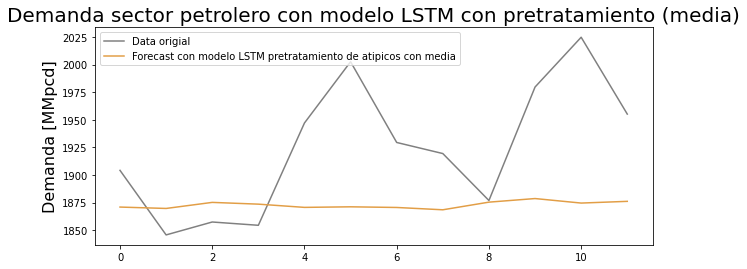

In [58]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#E29E46')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM pretratamiento de atipicos con media'))

plt.title('Demanda sector petrolero con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [59]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_media = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_media)
RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_media = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_media)

MAPE: 0.03157041673914799
RMSE: 76.70513823776682


Se muestra la comparación del forecast de demanda electrico con modelo FFNN entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

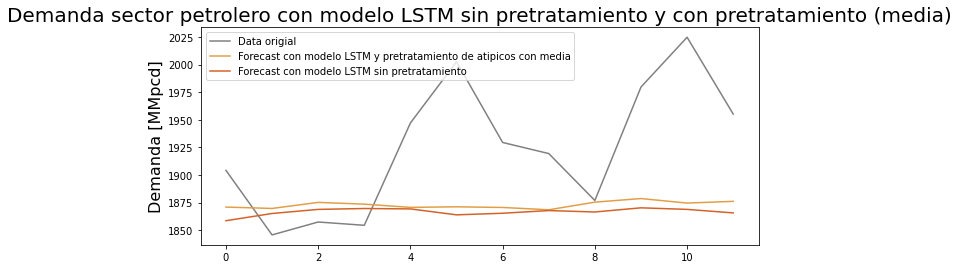

In [60]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media  , color='#E29E46')
plt.plot(test_predictions_model_LSTM_petrolero_sin_pretratamiento, color='#D66127')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector petrolero con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [61]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [62]:
outlier_threshold = 1.1

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [63]:
demanda_petrolero_original_train_para_tratamiento2 = demanda_petrolero_original_train_data.copy()
demanda_petrolero_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


In [65]:
demanda_petrolero_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_petrolero_original_train_para_tratamiento2['Demanded_Gas'])
demanda_petrolero_train_pretratamiento_mediana.tail(10)

Date
2020-12-01    1802.580
2021-01-01    1819.260
2021-02-01    1778.160
2021-03-01    1743.170
2021-04-01    2154.035
2021-05-01    1785.320
2021-06-01    1870.670
2021-07-01    1889.200
2021-08-01    1933.020
2021-09-01    1956.840
Name: Demanded_Gas, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

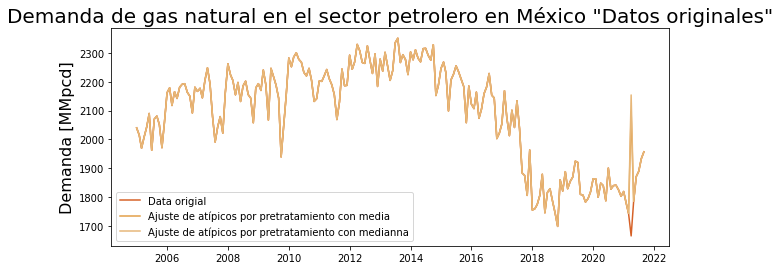

In [66]:
plt.figure(figsize=(10,4))
plt.plot(demanda_petrolero_original_train_data, color='#D66127')
plt.plot(demanda_petrolero_train_pretratamiento_media,color='#E29E46')
plt.plot(demanda_petrolero_train_pretratamiento_mediana,  color='#E7B779')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con medianna'))
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

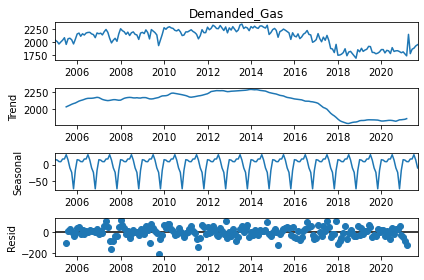

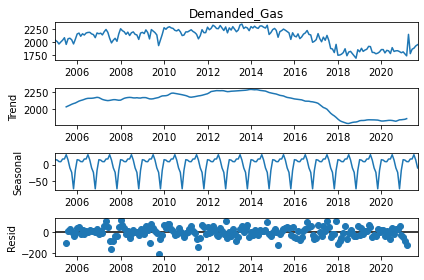

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_petrolero_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_petrolero_train_pretratamiento_mediana)
demanda_petrolero_train_pretratamiento_mediana_seasonal_decomposition.plot()


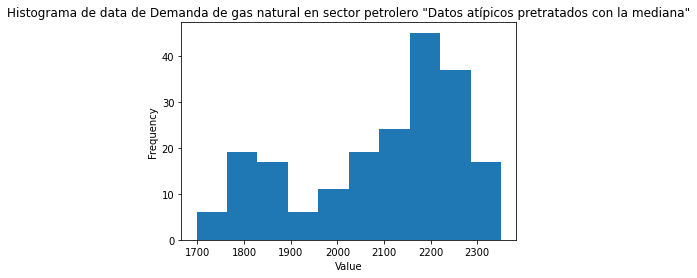

In [68]:
# Generate the histogram
plt.hist(demanda_petrolero_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [69]:
import scipy.stats as stats

# Assuming demanda_petrolero_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.289644016992085
p-value: 3.927894204602822e-05


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [70]:
n_input = 24

data = demanda_petrolero_train_pretratamiento_mediana
targets = data 

demanda_petrolero_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_petrolero_train_generator_pretratamiento_mediana[0]

(array([[2039.88, 2015.25, 1969.51, 2008.19, 2041.86, 2089.82, 1962.26,
         2070.46, 2080.82, 2050.56, 1971.14, 2059.68, 2161.66, 2178.75,
         2117.61, 2165.25, 2142.03, 2180.68, 2191.06, 2193.12, 2163.43,
         2150.04, 2091.42, 2180.87]]),
 array([2166.37]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [71]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [72]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [73]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_pretratamiento_mediana = Sequential()

model_LSTM_petrolero_pretratamiento_mediana.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_pretratamiento_mediana.add(Dense(1))
model_LSTM_petrolero_pretratamiento_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_petrolero_pretratamiento_mediana.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se entrena el modelo 

In [74]:
model_LSTM_petrolero_pretratamiento_mediana.fit(demanda_petrolero_train_generator_pretratamiento_mediana, epochs=15)

Epoch 1/15


177/177 [==============================] - 4s 9ms/step - loss: 4196538.5000
Epoch 2/15
177/177 [==============================] - 1s 8ms/step - loss: 996637.6250
Epoch 3/15
177/177 [==============================] - 1s 8ms/step - loss: 573267.4375
Epoch 4/15
177/177 [==============================] - 2s 9ms/step - loss: 31155.1855
Epoch 5/15
177/177 [==============================] - 2s 8ms/step - loss: 77792.5234
Epoch 6/15
177/177 [==============================] - 2s 8ms/step - loss: 13783.2158
Epoch 7/15
177/177 [==============================] - 2s 9ms/step - loss: 13453.1240
Epoch 8/15
177/177 [==============================] - 2s 8ms/step - loss: 12465.3613
Epoch 9/15
177/177 [==============================] - 2s 9ms/step - loss: 13342.9814
Epoch 10/15
177/177 [==============================] - 1s 8ms/step - loss: 11772.6689
Epoch 11/15
177/177 [==============================] - 1s 8ms/step - loss: 10517.6748
Epoch 12/15
177/177 [==============================] - 1s 8ms/step - l

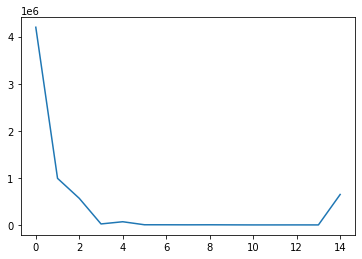

In [75]:
loss_per_epoch = model_LSTM_petrolero_pretratamiento_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [76]:
demanda_petrolero_train_batch_pretratamiento_mediana = demanda_petrolero_train_pretratamiento_mediana.values[-n_input:]


demanda_petrolero_train_batch_pretratamiento_mediana

array([1782.6  , 1794.63 , 1818.35 , 1863.28 , 1863.28 , 1799.17 ,
       1848.19 , 1839.68 , 1786.97 , 1900.31 , 1827.31 , 1839.67 ,
       1841.23 , 1824.71 , 1802.58 , 1819.26 , 1778.16 , 1743.17 ,
       2154.035, 1785.32 , 1870.67 , 1889.2  , 1933.02 , 1956.84 ])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [77]:
demanda_petrolero_train_batch_pretratamiento_mediana_reshaped = demanda_petrolero_train_batch_pretratamiento_mediana.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_pretratamiento_mediana_reshaped

array([[[1782.6  ],
        [1794.63 ],
        [1818.35 ],
        [1863.28 ],
        [1863.28 ],
        [1799.17 ],
        [1848.19 ],
        [1839.68 ],
        [1786.97 ],
        [1900.31 ],
        [1827.31 ],
        [1839.67 ],
        [1841.23 ],
        [1824.71 ],
        [1802.58 ],
        [1819.26 ],
        [1778.16 ],
        [1743.17 ],
        [2154.035],
        [1785.32 ],
        [1870.67 ],
        [1889.2  ],
        [1933.02 ],
        [1956.84 ]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [78]:
model_LSTM_petrolero_pretratamiento_mediana.predict(demanda_petrolero_train_batch_pretratamiento_mediana_reshaped)

1/1 [==============================] - 0s 223ms/step


array([[2562.8682]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [79]:
n_input = 24
n_features = 1

In [80]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana  = []

first_eval_batch = demanda_petrolero_train_pretratamiento_mediana.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_pretratamiento_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 35ms/step


In [81]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana

[array([2562.8682], dtype=float32),
 array([2076.326], dtype=float32),
 array([-335.5795], dtype=float32),
 array([904.6958], dtype=float32),
 array([2802.0203], dtype=float32),
 array([538.73145], dtype=float32),
 array([463.87326], dtype=float32),
 array([-329.71594], dtype=float32),
 array([451.68066], dtype=float32),
 array([642.21265], dtype=float32),
 array([501.71332], dtype=float32),
 array([536.1478], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

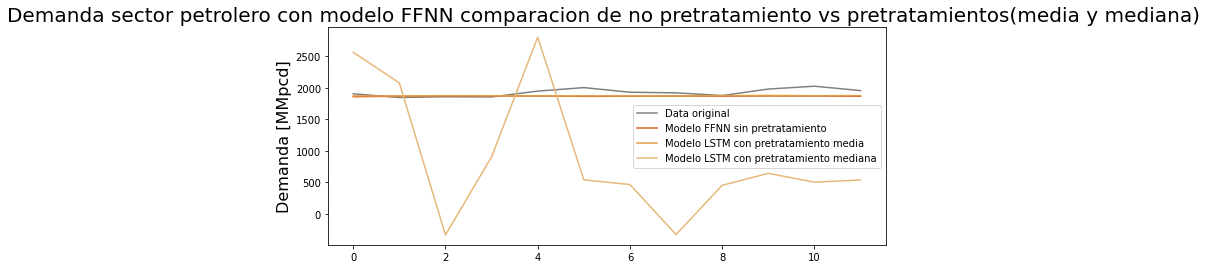

In [82]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_sin_pretratamiento,  color='#D66127')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#E29E46')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_mediana ,  color='#E7B779')
plt.legend(('Data original', 'Modelo FFNN sin pretratamiento', 'Modelo LSTM con pretratamiento media', 'Modelo LSTM con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector petrolero con modelo FFNN comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [83]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_mediana )
RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_mediana ))

print('MAPE:', MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana)

MAPE: 0.6815014922250406
RMSE: 1426.8916965383792
